# Absolute and Weighted Frequency of Words in Text

<!-- I would make this intro a bit stronger even ---> 
An important set of metrics in text mining relates to the frequency of words (or any token) in a certain corpus of text documents. However, you can also use an additional set of metrics in cases where each document has an associated numeric value describing a certain attribute of the document. 

Some examples:  
* Tweets and their respective number of engagements.
* URLs and their pageviews and bounces.
* Movie titles and their gross revenue. 
* Keywords and their impressions, clicks, and conversions.

In this tutorial, 

- You will first go through the process of creating a simple function that calculates and compares the absolute and weighted occurrence of words in a corpus of documents. This can sometimes uncover hidden trends and aggregates that aren't necessarily clear by looking at the top ten or so values. They can often be different from the absolute word frequency as well.  
- Then, you will see a real-life data set (movie titles and the gross revenue), and hope to discover hidden trends. A teaser: love will come up somehow!
- You will be using Python as a programming language and use the `collections` module's `defaultdict` data structure for the heavy lifting, as well as pandas `DataFrame`s to manage the final output.  

## Absolute and Weighted Word Frequency: Introduction 

Let's assume that you have two tweets and that their content and number of impressions (views) are as follows: 

Tweet Text | Views
----------|--------
spain| 800
france| 200


It is simple to do the basic analysis and find out that your words are split 50:50 between 'france' and 'spain'. In many cases, this is all you have, and you can only measure the absolute frequency of words, and try to infer certain relationships. In this case, you have some data about each of the documents.  

The weighed frequency here, is clearly different, and the split is 80:20. In other words, although 'spain' and 'france' both appeared once each in your tweets, from your readers' perspective, the former appeared 800 times, while the latter appeared 200 times. There's a big difference!

### Simple Word Frequency using `defaultdict`

Now consider this slightly more involved example for a similar set of documents: 

Document | Views
----------|--------
france| 200
spain| 180
spain beaches| 170
france beaches| 160
spain best beaches| 160

You now loop through the documents, split them into words, and count the occurrences of each of the words:

In [1]:
from collections import defaultdict

import pandas as pd

text_list = ['france', 'spain', 'spain beaches', 'france beaches', 'spain best beaches']

word_freq = defaultdict(int)

for text in text_list:
    for word in text.split():
        word_freq[word] += 1
    
pd.DataFrame.from_dict(word_freq, orient='index') \
.sort_values(0, ascending=False) \
.rename(columns={0: 'abs_freq'})

,abs_freq
spain,3
beaches,3
france,2
best,1


In the loop above, the first line loops through `text_list` one by one. The second line (within each document) loops through the words of each item, split by the space character (which could have been any other character ('-', ',', '\_', etc.)).  

When you try to assign a value to `word_freq[word]` there are two possible scenarios: 
1. The key `word` exists: in which case the assignment is done (adding one)
2. The key `word` is not in `word_freq`,  in this case `defaultdict` calls the default function that it was assigned to when it was first defined, which is `int` in this case. 

When `int` is called it returns zero. Now the key exists, its value is zero, and it is ready to get assigned an additional 1 to its value. 

Although the top word was 'france' in the first table, after counting all the words within each document we can see that 'spain' and 'beaches' are tied for the first position. This is important in uncovering hidden trends, especially when the list of documents you are dealing with, is in the tens, or hundreds,  of thousands. 

### Weighted Word Frequency

Now that you have counted the occurences of each word in the corpus of documents, you want to see the weighted frequency. That is, you want to see how many times the words appeared to your readers, compared to how many times you used them.  

In the first table, the absolute frequency of the words was split evenly between 'spain' and 'france', but 'spain' had clearly much more weight, because its value was 800, versus 200 or 'france'.  

But what would be the weighted word frequency for the second, slightly more complex, table?

Let's find out! 

You can re-use some of the code that you used above, but with some additions:

In [2]:
# default value is now a list with two ints
word_freq = defaultdict(lambda: [0, 0]) 

num_list = [200, 180, 170, 160, 160] # the 'views' column we had in the first DataFrame

# looping is now over both the text and the numbers
for text, num in zip(text_list, num_list): 
    for word in text.split(): 
        # same as before
        word_freq[word][0] += 1 
        # new line, incrementing the numeric value for each word
        word_freq[word][1] += num 

columns = {0: 'abs_freq', 1: 'wtd_freq'}
        
abs_wtd_df = pd.DataFrame.from_dict(word_freq, orient='index') \
             .rename(columns=columns) \
             .sort_values('wtd_freq', ascending=False) \
             .assign(rel_value=lambda df: df['wtd_freq'] / df['abs_freq']) \
            .round()

abs_wtd_df.style.background_gradient(low=0, high=.7, subset=['rel_value'])

,abs_freq,wtd_freq,rel_value
spain,3,510,170
beaches,3,490,163
france,2,360,180
best,1,160,160


Some observations:

* Although 'france' was the highest phrase overall, 'spain' and 'beaches' seem to be more prominent when you take the weighted frequency. 
* `rel_value` is a simple division to get the value per occurrence of each word. 
* Looking at `rel_value`, you also see that, even though 'france' is quite low on the `wtd_freq` metric, there seems to be potential in it, because the value per occurence is high. This might hint at increasing your content coverage of 'france' for example.

You might also like to add some other metrics that show the percentages and cumulative percenatages of each type of frequency so that you can get a better perspective on how many words form the bulk of the total, if any:

In [3]:
abs_wtd_df.insert(1, 'abs_perc', value=abs_wtd_df['abs_freq'] / abs_wtd_df['abs_freq'].sum())
abs_wtd_df.insert(2, 'abs_perc_cum', abs_wtd_df['abs_perc'].cumsum())
abs_wtd_df.insert(4, 'wtd_freq_perc', abs_wtd_df['wtd_freq'] / abs_wtd_df['wtd_freq'].sum())
abs_wtd_df.insert(5, 'wtd_freq_perc_cum', abs_wtd_df['wtd_freq_perc'].cumsum())
abs_wtd_df.style.background_gradient(low=0, high=0.8)

,abs_freq,abs_perc,abs_perc_cum,wtd_freq,wtd_freq_perc,wtd_freq_perc_cum,rel_value
spain,3,0.333333,0.333333,510,0.335526,0.335526,170
beaches,3,0.333333,0.666667,490,0.322368,0.657895,163
france,2,0.222222,0.888889,360,0.236842,0.894737,180
best,1,0.111111,1,160,0.105263,1,160


<!--- what does this mean? ---> More can be analyzed, and with more data you would typically get more surprises. 

So how might this look in a real-world setting with some real data?

You will take a look at movie titles, see which words are most used in the titles -which is the absolute frequency-, and which words are associated with the most revenue, or the weighted frequency.  

[Boxoffice Mojo](http://www.boxofficemojo.com/alltime/domestic.htm) has a list of more than 15,000 movies, together with their associated gross revenue and ranks. Start by scraping the data using `requests` and `BeautifulSoup`:

In [4]:
import requests
from bs4 import BeautifulSoup

In [5]:
final_list = []

for i in range(1, 156):
    page = 'http://www.boxofficemojo.com/alltime/domestic.htm?page=' + str(i) + '&p=.htm'
    resp = requests.get(page)
    soup = BeautifulSoup(resp.text, 'lxml')
    # trial and error to get the exact positions
    table_data = [x.text for x in soup.select('tr td')[11:511]]  
    # put every 5 values in a row
    temp_list = [table_data[i:i+5] for i in range(0, len(table_data[:-4]), 5)] 
    for temp in temp_list:
        final_list.append(temp)

In [6]:
boxoffice_df = pd.DataFrame.from_records(final_list)

boxoffice_df.head(10)

,0,1,2,3,4
0,1,Star Wars: The Force Awakens,BV,"$936,662,225",2015
1,2,Avatar,Fox,"$760,507,625",2009^
2,3,Black Panther,BV,"$681,374,736",2018
3,4,Titanic,Par.,"$659,363,944",1997^
4,5,Jurassic World,Uni.,"$652,270,625",2015
5,6,Marvel's The Avengers,BV,"$623,357,910",2012
6,7,Star Wars: The Last Jedi,BV,"$620,181,382",2017
7,8,The Dark Knight,WB,"$534,858,444",2008^
8,9,Rogue One: A Star Wars Story,BV,"$532,177,324",2016
9,10,Beauty and the Beast (2017),BV,"$504,014,165",2017


In [7]:
boxoffice_df.tail(15)

,0,1,2,3,4
15385,15486,Triumph of the Wall,FRun,$476,2013
15386,15487,Rome & Jewel,Emr.,$470,2008
15387,15488,Green is Gold,Gold.,$455,2016
15388,15489,Serum,Arv.,$440,2006
15389,15490,The Dark Hours,N/A,$423,2005
15390,15491,2:22,Magn.,$422,2017
15391,15492,State Park,Atl,$421,1988
15392,15493,The Magician (2010),Reg.,$406,2010
15393,15494,Skinless,PPF,$400,2014
15394,15495,Cinemanovels,Mont.,$398,2014


You will see that some numeric values have some special characters, (`$`, `,` , and `^`), and some values are actually `N/A`. So you need to change those:

In [8]:
na_year_idx =  [i for i, x in enumerate(final_list) if x[4] == 'n/a'] # get the indexes of the 'n/a' values
new_years = [1998, 1999, 1960, 1973]  # got them by checking online

print(*[(i, x) for i, x in enumerate(final_list) if i in na_year_idx], sep='\n')
print('new year values:', new_years)

(7905, ['8006', 'Warner Bros. 75th Anniversary Film Festival', 'WB', '$741,855', 'n/a'])
(8048, ['8149', 'Hum Aapke Dil Mein Rahte Hain', 'Eros', '$668,678', 'n/a'])
(8097, ['8198', 'Purple Moon (Re-issue)', 'Mira.', '$640,945', 'n/a'])
(10371, ['10472', 'Amarcord', 'Jan.', '$125,493', 'n/a'])
new year values: [1998, 1999, 1960, 1973]


In [9]:
for na_year, new_year in zip(na_year_idx, new_years):
    final_list[na_year][4] = new_year
    print(final_list[na_year], new_year)

['8006', 'Warner Bros. 75th Anniversary Film Festival', 'WB', '$741,855', 1998] 1998
['8149', 'Hum Aapke Dil Mein Rahte Hain', 'Eros', '$668,678', 1999] 1999
['8198', 'Purple Moon (Re-issue)', 'Mira.', '$640,945', 1960] 1960
['10472', 'Amarcord', 'Jan.', '$125,493', 1973] 1973


Now you turn the list into a pandas `DataFrame` by naming the columns with the appropriate names, and converting to the data types that you want. 

In [10]:
import re
regex = '|'.join(['\$', ',', '\^'])

columns = ['rank', 'title', 'studio', 'lifetime_gross', 'year']

boxoffice_df = pd.DataFrame({
    'rank': [int(x[0]) for x in final_list],  # convert ranks to integers
    'title': [x[1] for x in final_list],  # get titles as is
    'studio': [x[2] for x in final_list],  # get studio names as is
    'lifetime_gross': [int(re.sub(regex, '', x[3])) for x in final_list],  # remove special characters and convert to integer
    'year': [int(re.sub(regex, '', str(x[4]))) for x in final_list],  # remove special characters and convert to integer
})
print('rows:', boxoffice_df.shape[0])
print('columns:', boxoffice_df.shape[1])
print('\ndata types:')
print(boxoffice_df.dtypes)
boxoffice_df.head(15)

rows: 15400
columns: 5

data types:
lifetime_gross     int64
rank               int64
studio            object
title             object
year               int64
dtype: object


,lifetime_gross,rank,studio,title,year
0,936662225,1,BV,Star Wars: The Force Awakens,2015
1,760507625,2,Fox,Avatar,2009
2,681374736,3,BV,Black Panther,2018
3,659363944,4,Par.,Titanic,1997
4,652270625,5,Uni.,Jurassic World,2015
5,623357910,6,BV,Marvel's The Avengers,2012
6,620181382,7,BV,Star Wars: The Last Jedi,2017
7,534858444,8,WB,The Dark Knight,2008
8,532177324,9,BV,Rogue One: A Star Wars Story,2016
9,504014165,10,BV,Beauty and the Beast (2017),2017


The word 'star' is one of the top, as it appears in five of the top fifteen movies, and you also know that the Star Wars series has even more movies, several of them in the top as well.

Let's now utilize the code you developed and see how it works on this data set. There's nothing new in the code below, you simply put it all in one function:

In [11]:
def word_frequency(text_list, num_list, sep=None):
    word_freq = defaultdict(lambda: [0, 0])

    for text, num in zip(text_list, num_list):
        for word in text.split(sep=sep): 
            word_freq[word][0] += 1 
            word_freq[word][1] += num

    columns = {0: 'abs_freq', 1: 'wtd_freq'}

    abs_wtd_df = (pd.DataFrame.from_dict(word_freq, orient='index')
                 .rename(columns=columns )
                 .sort_values('wtd_freq', ascending=False)
                 .assign(rel_value=lambda df: df['wtd_freq'] / df['abs_freq']).round())

    abs_wtd_df.insert(1, 'abs_perc', value=abs_wtd_df['abs_freq'] / abs_wtd_df['abs_freq'].sum())
    abs_wtd_df.insert(2, 'abs_perc_cum', abs_wtd_df['abs_perc'].cumsum())
    abs_wtd_df.insert(4, 'wtd_freq_perc', abs_wtd_df['wtd_freq'] / abs_wtd_df['wtd_freq'].sum())
    abs_wtd_df.insert(5, 'wtd_freq_perc_cum', abs_wtd_df['wtd_freq_perc'].cumsum())

    return abs_wtd_df
word_frequency(boxoffice_df['title'], boxoffice_df['lifetime_gross']).head()

,abs_freq,abs_perc,abs_perc_cum,wtd_freq,wtd_freq_perc,wtd_freq_perc_cum,rel_value
The,3033,0.068676,0.068676,66244644219,0.081167,0.081167,21841294.0
the,1307,0.029594,0.098270,32804496553,0.040194,0.121361,25099079.0
of,1395,0.031587,0.129857,29903729443,0.036640,0.158000,21436365.0
and,543,0.012295,0.142152,12076294801,0.014797,0.172797,22239954.0
2,157,0.003555,0.145707,8978709325,0.011001,0.183798,57189231.0


Unsurprisingly, the 'stop words' are the top ones, which is pretty much the same for most collections of documents. You also have them duplicated, where some are capitalized and some are not. So you have two clear things to take care of: 
1. Remove all stop words: you can do this by adding a new parameter to the function, and supplying your own list of stop words.
2. Handle all words in lower case to remove duplicates

Here is a simple update to the function (new `rm_words` parameter, as well as lines 6,7, and 8):

In [12]:
# words will be expanded
def word_frequency(text_list, num_list, sep=None, rm_words=('the', 'and', 'a')):  
    word_freq = defaultdict(lambda: [0, 0])

    for text, num in zip(text_list, num_list):
        for word in text.split(sep=sep): 
            # This should take care of ignoring the word if it's in the stop words
            if word.lower() in rm_words:  
                continue                  
            # .lower() makes sure we are not duplicating words
            word_freq[word.lower()][0] += 1  
            word_freq[word.lower()][1] += num

    columns = {0: 'abs_freq', 1: 'wtd_freq'}

    abs_wtd_df = (pd.DataFrame.from_dict(word_freq, orient='index')
                 .rename(columns=columns )
                 .sort_values('wtd_freq', ascending=False)
                 .assign(rel_value=lambda df: df['wtd_freq'] / df['abs_freq']).round())

    abs_wtd_df.insert(1, 'abs_perc', value=abs_wtd_df['abs_freq'] / abs_wtd_df['abs_freq'].sum())
    abs_wtd_df.insert(2, 'abs_perc_cum', abs_wtd_df['abs_perc'].cumsum())
    abs_wtd_df.insert(4, 'wtd_freq_perc', abs_wtd_df['wtd_freq'] / abs_wtd_df['wtd_freq'].sum())
    abs_wtd_df.insert(5, 'wtd_freq_perc_cum', abs_wtd_df['wtd_freq_perc'].cumsum())
    
    abs_wtd_df = abs_wtd_df.reset_index().rename(columns={'index': 'word'})

    return abs_wtd_df

In [13]:
from collections import defaultdict
word_freq_df =  word_frequency(boxoffice_df['title'], 
                               boxoffice_df['lifetime_gross'],
                               rm_words=['of','in', 'to', 'and', 'a', 'the', 
                                         'for', 'on', '&', 'is', 'at', 'it',
                                         'from', 'with'])



word_freq_df.head(15).style.bar(['abs_freq', 'wtd_freq', 'rel_value'],
                                               color='#60DDFF') # E6E9EB

,word,abs_freq,abs_perc,abs_perc_cum,wtd_freq,wtd_freq_perc,wtd_freq_perc_cum,rel_value
0,2,157,0.00443979,0.00443979,8978709325,0.0139567,0.0139567,5.71892e+07
1,star,45,0.00127255,0.00571235,5374658819,0.00835448,0.0223112,1.19437e+08
2,man,194,0.00548612,0.0111985,3910068952,0.00607789,0.0283891,2.0155e+07
3,part,41,0.00115944,0.0123579,3262579777,0.00507142,0.0334605,7.95751e+07
4,movie,117,0.00330864,0.0156665,3216050557,0.0049991,0.0384596,2.74876e+07
5,3,61,0.00172502,0.0173916,3088019597,0.00480008,0.0432597,5.06233e+07
6,ii,67,0.00189469,0.0192862,3077712883,0.00478406,0.0480437,4.5936e+07
7,wars:,6,0.000169674,0.0194559,2757497155,0.00428631,0.0523301,4.59583e+08
8,last,133,0.0037611,0.023217,2670229651,0.00415066,0.0564807,2.00769e+07
9,harry,27,0.000763531,0.0239805,2611329714,0.00405911,0.0605398,9.67159e+07


Let's take a look at the same DataFrame sorted based on `abs_freq`:

In [14]:
(word_freq_df.sort_values('abs_freq', ascending=False)
 .head(15)
    .style.bar(['abs_freq', 'wtd_freq', 'rel_value'],
               color='#60DDFF'))

,word,abs_freq,abs_perc,abs_perc_cum,wtd_freq,wtd_freq_perc,wtd_freq_perc_cum,rel_value
25,love,211,0.00596686,0.0678695,1604226709,0.00249364,0.109909,7.60297e+06
2,man,194,0.00548612,0.0111985,3910068952,0.00607789,0.0283891,2.0155e+07
23,my,191,0.00540128,0.0607149,1629549791,0.00253301,0.104905,8.53167e+06
16,i,166,0.0046943,0.0417114,2092932553,0.0032533,0.0852373,1.2608e+07
0,2,157,0.00443979,0.00443979,8978709325,0.0139567,0.0139567,5.71892e+07
10,me,139,0.00393077,0.0279113,2403099306,0.00373543,0.0642752,1.72885e+07
31,life,134,0.00378938,0.0765228,1534647732,0.00238549,0.124488,1.14526e+07
8,last,133,0.0037611,0.023217,2670229651,0.00415066,0.0564807,2.00769e+07
22,you,125,0.00353487,0.0553136,1658024889,0.00257727,0.102372,1.32642e+07
4,movie,117,0.00330864,0.0156665,3216050557,0.0049991,0.0384596,2.74876e+07


Now let's visualize to compare both and see the hidden trends: 

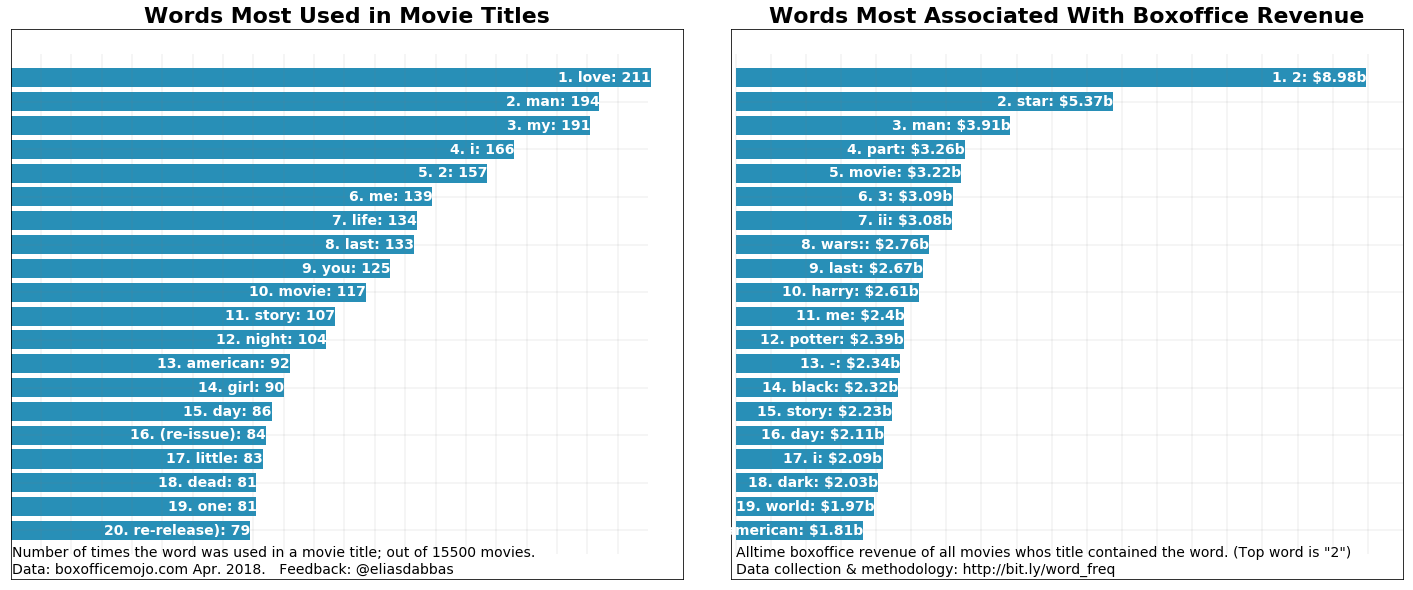

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)

word_freq_df_abs = word_freq_df.sort_values('abs_freq', ascending=False).reset_index()

plt.barh(range(20),
         list(reversed(word_freq_df_abs['abs_freq'][:20])), color='#288FB7')
for i, word in enumerate(word_freq_df_abs['word'][:20]):
    plt.text(word_freq_df_abs['abs_freq'][i], 20-i-1, 
             s=str(i+1) + '. ' + word + ': '  + str(word_freq_df_abs['abs_freq'][i]),
             ha='right', va='center', fontsize=14, color='white', fontweight='bold')
plt.text(0.4, -1.1, s='Number of times the word was used in a movie title; out of 15500 movies.', fontsize=14)
plt.text(0.4, -1.8, s='Data: boxofficemojo.com Apr. 2018.   Feedback: @eliasdabbas', fontsize=14)


plt.vlines(range(0, 210, 10), -1, 20, colors='gray', alpha=0.1)
plt.hlines(range(0, 20, 2), 0, 210, colors='gray', alpha=0.1)
plt.yticks([])
plt.xticks([])
plt.title('Words Most Used in Movie Titles', fontsize=22, fontweight='bold')

# =============
plt.subplot(1, 2, 2)
# plt.axis('off')
plt.barh(range(20),
         list(reversed(word_freq_df['wtd_freq'][:20])), color='#288FB7')
for i, word in enumerate(word_freq_df['word'][:20]):
    plt.text(word_freq_df['wtd_freq'][i], 20-i-1, 
             s=str(i+1) + '. ' + word + ': ' + '$' + str(round(word_freq_df['wtd_freq'][i] / 1000_000_000, 2)) + 'b',
             ha='right', va='center', fontsize=14, color='white', fontweight='bold')
plt.text(0.4, -1.1, s='Alltime boxoffice revenue of all movies whos title contained the word. (Top word is "2") ', fontsize=14)
plt.text(0.4, -1.8, s='Data collection & methodology: http://bit.ly/word_freq', fontsize=14)

plt.vlines(range(0, 9_500_000_000, 500_000_000), -1, 20, colors='gray', alpha=0.1)
plt.hlines(range(0, 20, 2), 0, 10_000_000_000, colors='gray', alpha=0.1)
plt.xlim((-70_000_000, 9_500_000_000))
plt.yticks([])
plt.xticks([])
plt.title('Words Most Associated With Boxoffice Revenue', fontsize=22, fontweight='bold')
plt.tight_layout(pad=0.01)
plt.show()


It seems that in the minds of producers and writers at least, love does conquer all! It is the most used word in all of the movie titles. It is not that high when it comes to weighted frequency (box-office revenue), though. 

In other words, if you look at all the titles of movies, the word 'love' would be the one you would most find. But estimating which word appeared the most in the eyes of the viewers (using gross revenue as a metric), then '2', 'star', and 'man' would be the most viewed, or associated with the most revenue.

Just to be clear: these are very simple calculations. When you say that the weighted frequency of the word 'love' is  1,604,106,767, it simply means that the sum of the lifetime gross of all movies who's title included the word 'love' was that amount. 

It's also interesting that '2' is the top word. Obviously, it is not a word, but it's an indication that the second parts of movie series amount to a very large sum. So is '3', which is in the fifth position. Note that 'part' and 'ii' are also in the top ten, confirming the same fact. 
 
'American', and 'movie', have high relative value. 

**A quick note on the stop words used in this function**

Usually, you would supply a more comprehensive list of stop words than the one here, especially if you are dealing with articles, or social media posts. For example the `nltk` package provides lists of stop words in several languages, and these can be downloaded and used.  

The words here were chosen after a few checks on the top movies. Many of these are usually considered stop words, but in the case of movie titles, it made sense to keep some of them as they might give some insight. For example, the words 'I', 'me', 'you' might hint at some social dynamics. Another reason is that movie titles are very short phrases, and we are trying to make as much sense as we can from them.

You can definitely try it with your own set of words, and see slightly different results. 

Looking back at the original list of movie titles, we see that some of the top words don't even appear in the top ten, and this is exactly the kind of insight that we are  trying to uncover by using this approach. 

In [16]:
boxoffice_df.head(10)

,lifetime_gross,rank,studio,title,year
0,936662225,1,BV,Star Wars: The Force Awakens,2015
1,760507625,2,Fox,Avatar,2009
2,681374736,3,BV,Black Panther,2018
3,659363944,4,Par.,Titanic,1997
4,652270625,5,Uni.,Jurassic World,2015
5,623357910,6,BV,Marvel's The Avengers,2012
6,620181382,7,BV,Star Wars: The Last Jedi,2017
7,534858444,8,WB,The Dark Knight,2008
8,532177324,9,BV,Rogue One: A Star Wars Story,2016
9,504014165,10,BV,Beauty and the Beast (2017),2017


Next, I think it would make sense to further explore the top words that are interesting. Let's filter the movies that contain '2' and see: 

In [17]:
(boxoffice_df[boxoffice_df['title']                  
              .str
              .contains('2 | 2', case=False)] # spaces used to exclude words like '2010'
              .head(10)) 

,lifetime_gross,rank,studio,title,year
15,441226247,16,DW,Shrek 2,2004
30,389813101,31,BV,Guardians of the Galaxy Vol. 2,2017
31,381011219,32,WB,Harry Potter and the Deathly Hallows Part 2,2011
35,373585825,36,Sony,Spider-Man 2,2004
38,368061265,39,Uni.,Despicable Me 2,2013
64,312433331,65,Par.,Iron Man 2,2010
79,292324737,80,LG/S,The Twilight Saga: Breaking Dawn Part 2,2012
87,281723902,88,LGF,The Hunger Games: Mockingjay - Part 2,2015
117,245852179,118,BV,Toy Story 2,1999
146,226164286,147,NL,Rush Hour 2,2001


Let's also take a peek at the top 'star' movies:

In [18]:
boxoffice_df[boxoffice_df['title'].str.contains('star | star', case=False)].head(10)

,lifetime_gross,rank,studio,title,year
0,936662225,1,BV,Star Wars: The Force Awakens,2015
6,620181382,7,BV,Star Wars: The Last Jedi,2017
8,532177324,9,BV,Rogue One: A Star Wars Story,2016
11,474544677,12,Fox,Star Wars: Episode I - The Phantom Menace,1999
12,460998007,13,Fox,Star Wars,1977
33,380270577,34,Fox,Star Wars: Episode III - Revenge of the Sith,2005
65,310676740,66,Fox,Star Wars: Episode II - Attack of the Clones,2002
105,257730019,106,Par.,Star Trek,2009
140,228778661,141,Par.,Star Trek Into Darkness,2013
301,158848340,302,Par.,Star Trek Beyond,2016


And, lastly, the top 'man' movies:

In [19]:
boxoffice_df[boxoffice_df['title'].str.contains('man | man', case=False)].head(10)

,lifetime_gross,rank,studio,title,year
18,423315812,19,BV,Pirates of the Caribbean: Dead Man's Chest,2006
22,409013994,23,BV,Iron Man 3,2013
35,373585825,36,Sony,Spider-Man 2,2004
48,336530303,49,Sony,Spider-Man 3,2007
53,330360194,54,WB,Batman v Superman: Dawn of Justice,2016
59,318412101,60,Par.,Iron Man,2008
64,312433331,65,Par.,Iron Man 2,2010
82,291045518,83,WB,Man of Steel,2013
176,206852432,177,WB,Batman Begins,2005
182,202853933,183,Sony,The Amazing Spider-Man 2,2014


## Next steps and Improvements

<!-- I would write this out in full so that you have a conclusion? ---> 

* Get more words: movie titles are extremely short and many times don't convey the literal meaning of the words. For example, a godfather is supposed to be a person who whitnesses a child's christening, and promises to take care of that child (or maybe a mafioso who kills for pleasure?!).  
A further exercise might be to get more detailed descriptions, in addition to the movie title. For example: 

> "A computer hacker learns from mysterious rebels about the true nature of his reality and his role in the war against its controllers."  

tells us much more about the movie, than 'The Matrix'.

* Better statistical analysis: handling extreme values / outliers, using other metrics. 
* Text mining: grouping similar words and topics together ('happy', 'happiness', 'happily', etc.)
* Granlular analysis: running the same function for different years / decades, or for certain production studios. 

You might be interested in exploring the data yourself as well as other data: 

* [Boxoffice data](data/boxoffice.csv)
* [Gutenberg top 1,000 downloaded books](data/gutenberg.csv)
    - Which words are the most used in book titles? 
    - Which words are the most associated with book downloads? 
* [iPhone search keywords](data/iphone.csv) (obtained through [SERPs](https://serps.com/tools/keyword-research/))
    - What do people search for together with 'iphone'? 
    - What has the most weighted frequency? 

Ok, so now yo have explored the counts of words in movie titles, and seen the difference between the absolute and weighted frequencies, and how letting one out might miss a big part of the picture. You have also seen the limitations of this approach, and have some suggestions on how to improve your analysis.
You went through the process of creating a special function that you can run easily to analyze any similar text data set with numbers, and know how this can improve your understanding of this kind of data set.
Try it out by analyzing your tweets' performance, your website's URLs, your Facebook posts, or any other similar data set you might come across.

It might be easier to just [clone the repository](https://github.com/eliasdabbas/word_frequency) with the code and try for yourself.

The `word_frequency` function is part of the [advertools](https://github.com/eliasdabbas/advertools) package, which you can download and try using in your work / research. 

Check it out and let me know! [@eliasdabbas](https://twitter.com/eliasdabbas)